# Wordle algorithm

### Loading libraries and game data

In [1]:
import csv
import pickle
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Wordle_functions as wrdl

from IPython.display import clear_output
from time import sleep
from alive_progress import alive_it, config_handler

config_handler.set_global(force_tty=True, bar = "classic2", spinner = "classic", title='Playing Wordle intensively')

In [75]:
import importlib
importlib.reload(wrdl)
dir(wrdl);

The official version of Wordle has a list of words that it will allow you to enter, that are considered valid guesses, that's just about 13,000 words long. We will call the list of words all_allowed. But when you look at it there's a lot of really uncommon things things like "aahed" or "aalii" and "aargh". The kind of words that bring about family arguments in a game of Scrabble. But the vibe of the game is that the answer is always going to be a decently common word, and in fact there's another list of around 2,300 words that are the possible answers. We will call this list solutions. This is a human-curated list, I think specifically by the game creator's girlfriend which is kind of fun.
But what I would like to do, our challenge for this project, is to see if we can write a program solving Wordle that doesn't incorporate previous knowledge about this list. For one thing there's plenty of pretty common five letter words that you won't find in that list, so it would be better to write a program that's a little more resilient and would play Wordle against anyone, not just what happens to be the official website. And also, the reason that we know what this list of possible answers is is because it's visible in the source code, but the way that it's visible in the source code is in the specific order in which answers come up from day to day, so you could always just look up what tomorrow's answer will be. So clearly there's some sense in which using the list is cheating, and what makes for a more interesting puzzle and a richer information theory lesson is to instead use some more universal data, like relative word frequencies in general, to capture this intuition of having a preference for more common words.

In [2]:
#Importing solutions and allowed words to lists
csv_reader = csv.reader(open('solutions.csv', 'r'))
solutions = list(csv_reader)[0] #contains all possible solutions

csv_reader = csv.reader(open('allowed_words.csv', 'r'))
allowed_words = list(csv_reader)[0] #contains allowed words beside solutions

all_allowed = allowed_words + solutions

### Wordle algorithms!!!

#### Algorithm number 1: Picking random words
It's literally just taking a random guess from all allowed words until it finds a solution
It completly ignores information given from game

In [3]:
#takes around 40 seconds to run
def wordle_algorithm_1(solutions = solutions, allowed_words = all_allowed, max_tries = len(all_allowed), manual = False):
    """
    Wordle algorithm mark 1

        Args:
            solutions (list):       List of solutions (str) to iterate over. Is ignored if manual == True
            allowed_words (list):   List of strings with allowed words
            max_tries (int):        Max number of tries before giving up
            manual(bool):           If true, it asks for input for reply
            

        Returns:
            taken_tries (list):     list of int how many tries it took to solve for each solution
    """

    taken_tries = []
    if manual: solutions = ["a"]
    for s in alive_it(random.sample(solutions, len(solutions))):
        guess = random.sample(all_allowed, len(all_allowed))
        for i in range(max_tries):
            if manual:
                print(f"Try: {guess[i]}")
                sleep(1)
                reply = [int(item) for item in input("Wordl reply e.g. 0 2 1 0 0").split()]
                print(wrdl.wordle_print(reply), guess[i])
            else:
                reply = wrdl.wordle_reply(s, guess[i])
            
            #print(wrdl.wordle_print(reply), "", guess[i])
            if sum(reply) == 10:
                break
        taken_tries.append(i+1)
        clear_output(wait=True)
    return taken_tries

taken_tries = wordle_algorithm_1()
sleep(1)
print(f"Average number of tries: {(sum(taken_tries)/len(taken_tries)):.6}")

Playing Wordle intensively [########################################] 2309/2309 [100%] in 46.7s (49.42/s)               
Average number of tries: 6499.22


#### Algorithm number 2: Filtering word list down

We're using the function "filter_words" here.
Given a guess, a reply and a list of possible solutions, it filters the possible solution
by throwing out all impossible solutions.

In [3]:
#Testing filter_words function
solution = "grade"
guess = "cigar"
answer = wrdl.wordle_reply(solution, guess)
print(answer)

reduced_list = wrdl.filter_words(guess, answer, all_allowed)
print(f"Original solution space: {len(all_allowed)}. Now: {len(reduced_list)}. Reduced list by {1-(len(reduced_list)/len(all_allowed)):.2%}")

[0, 0, 1, 1, 1]
Original solution space: 12974. Now: 78. Reduced list by 99.40%


In [193]:
#takes 10 seconds to run
def wordle_algorithm_2(solutions = solutions, allowed_words = all_allowed, max_tries = len(all_allowed), manual = False):
    """
    Wordle algorithm mark 2: Makes use of the information from wordl reply by filtering out words
    that can't be the solution. Suggests random word from solution space that's left as next guess.

        Args:
            solutions (list):       List of solutions (str) to iterate over. Is ignored if manual == True
            allowed_words (list):   List of strings with allowed words
            max_tries (int):        Max number of tries before giving up
            manual(bool):           If true, it asks for input for reply
            

        Returns:
            taken_tries (list):     list of int how many tries it took to solve for each solution
    """
    
    taken_tries = []
    if manual:
        solutions = ["a"]

    for s in alive_it(solutions):
        guess = random.choice(allowed_words) #initial guess
        reduced_list = allowed_words
        #print(s)
        for i in range(max_tries): #reduces list over iterations
            if manual:
                print(f"Try: {guess}")
                sleep(1)
                reply = [int(item) for item in input("Wordl reply e.g. 0 2 1 0 0").split()]
                reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)
                print(wrdl.wordle_print(reply), guess, f"{len(reduced_list)} words")
            else:
                reply = wrdl.wordle_reply(s, guess)
                reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)

            guess = random.choice(reduced_list)

            if sum(reply) == 10:
                #print(i+1)
                break
        taken_tries.append(i+1)
        clear_output(wait=True)
    return taken_tries

taken_tries = wordle_algorithm_2()
invalid_guesses = [x for x in taken_tries if x > 6]
sleep(2)
print(f"Average number of tries:\t{sum(taken_tries)/len(taken_tries):.2}")
print(f"Number of losses:\t\t{len(invalid_guesses)} = {len(invalid_guesses)/len(solutions):.2%}")

Playing Wordle intensively [########################################] 2309/2309 [100%] in 8.2s (280.02/s)               
Average number of tries:	4.9
Number of losses:		243 = 10.52%


#### Algorithm to calculate entropy

Now we're calculating the expected entropy per word and choose the one with the greatest E[I]. For that we first need to generate a reply map with all possible replies we could get for a guess. Next we calculate the probability that a reply shows up for a given guess. From that
probability map we can calculate the expected entropy for a given guess. Let's test out the functions:

In [45]:
guess = "weary"
reply_map = wrdl.wordle_reply_generator()
gpm = wrdl.guess_probability_map(guess, all_allowed)
e = wrdl.expected_entropy_from_word(guess, all_allowed)
with open('entropy_db.pkl', 'rb') as x:
    entropy_db = pickle.load(x)

print(f"guess: {guess}")
print(f"reply map: {reply_map[:4]}")
print(f"reply, prob: {gpm[:2]}")
print(f"E[I]: {e}")
print(f"Loaded hashes: {len(entropy_db)}")

guess: weary
reply map: [[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0]]
reply, prob: [([0, 0, 0, 0, 0], 0.14213041467550486), ([0, 0, 0, 0, 1], 0.011484507476491445)]
E[I]: 4.902013055555522
Loaded hashes: 1


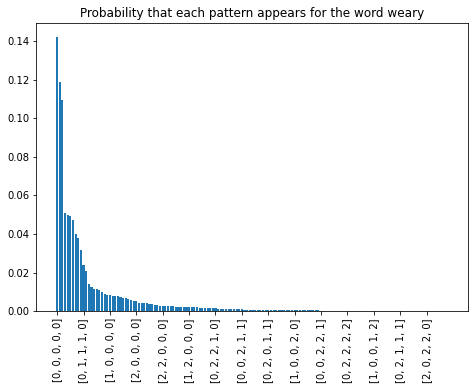

In [5]:
#plotting probability map for example word -> how likely each pattern is
guess = "weary"
gpm = wrdl.guess_probability_map(guess, all_allowed)
gpm = sorted(gpm, key=lambda tup: tup[1], reverse = True) #sorts the list
x, y = zip(*gpm)
x = [str(i) for i in x]

# x = df.index.values.tolist()
# y = df["Probability"].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.xticks(np.arange(0, len(x)+1, 10), rotation=90)

plt.title(f"Probability that each pattern appears for the word {guess}")
plt.show()

In [10]:
#build dataframe with words & expected entropy and save as df
# #for solutions
# entropies_all = []
# for word in alive_it(solutions, force_tty=True, bar = "classic2", spinner = "loving"):
#     entropies_all.append(expected_entropy_from_word(word))

# df = pd.DataFrame(list(zip(solutions, entropies_all)), columns = ["Word", "E[I]"])
# df = df.sort_values(by=['E[I]'], ascending=False)
# df.to_csv('solutions_E[I].csv', index=False)

# #for allowed_words (not all_allowed!)
# entropies_all = []
# for word in alive_it(allowed_words, force_tty=True, bar = "classic2", spinner = "loving"):
#     entropies_all.append(expected_entropy_from_word(word))

# df = pd.DataFrame(list(zip(allowed_words, entropies_all)), columns = ["Word", "E[I]"])
# df = df.sort_values(by=['E[I]'], ascending=False)
# df.to_csv('allowed_words_E[I].csv', index=False)

solutions_EI = pd.read_csv('solutions_E[I].csv', header=0, index_col=0).squeeze("columns").to_dict()
allowed_EI = pd.read_csv('allowed_words_E[I].csv', header=0, index_col=0).squeeze("columns").to_dict()
all_allowed_EI = {**allowed_EI, **solutions_EI}

for i in (solutions_EI, allowed_EI, all_allowed_EI):
    best_guess = max(i.keys(), key=(lambda k: i[k]))
    worst_guess = min(i.keys(), key=(lambda k: i[k]))

    print(f"best guess:\t{best_guess}\t{i[best_guess]:.3}")
    print(f"worst guess:\t{worst_guess}\t{i[worst_guess]:.3}\n")

best guess:	saner	6.0
worst guess:	fluff	2.35

best guess:	tares	6.19
worst guess:	qajaq	2.07

best guess:	tares	6.19
worst guess:	qajaq	2.07



In [13]:
hash_list = []
cur_hash = hash(str(hash_list))
#entropy_db[cur_hash]
all_allowed_EI

{'tares': 6.194226640047031,
 'lares': 6.150099641547228,
 'rales': 6.114222545555714,
 'rates': 6.096134764893258,
 'teras': 6.07690155746833,
 'nares': 6.067449403726547,
 'soare': 6.061508015137109,
 'tales': 6.054743952692028,
 'reais': 6.049679825269149,
 'tears': 6.032242820540562,
 'arles': 6.029534982396112,
 'tores': 6.018419713388626,
 'salet': 6.016604946893501,
 'aeros': 6.013685693484096,
 'dares': 6.010513713512872,
 'reals': 5.999041987716623,
 'lears': 5.988690787786636,
 'lores': 5.977086519338508,
 'serai': 5.9738995324363255,
 'lanes': 5.971286968371459,
 'laers': 5.9689440884246014,
 'pares': 5.96753160258437,
 'cares': 5.966591937162781,
 'tires': 5.963363988911771,
 'saine': 5.96272650621515,
 'seral': 5.953932586329753,
 'mares': 5.952006011912107,
 'reans': 5.951116233079341,
 'aloes': 5.944517028429678,
 'sared': 5.942792440486926,
 'roles': 5.941925157952631,
 'teals': 5.938016592980175,
 'aures': 5.930443542683765,
 'earls': 5.926840330218419,
 'taels': 5.920

In [75]:
#takes 2.5 minutes to run
def wordle_algorithm_3(solutions = solutions, allowed_words = all_allowed, \
    max_tries = len(all_allowed), manual = False, verbose = False, entropy_db = entropy_db):
    """
    Wordle algorithm mark 3: Makes use of the information from wordl reply by filtering out words
    that can't be the solution. Suggests guess with highest expected entropy from reduced solution
    space as next guess.

        Args:
            solutions (list):       List of solutions (str) to iterate over. Is ignored if manual == True
            allowed_words (list):   List of strings with allowed words
            max_tries (int):        Max number of tries before giving up
            manual(bool):           If true, it asks for input for reply
            verbose(bool):          If true lots of stuff is printed
            entropy_db(dict):       Dictionary of hashes with entropy list
            
        Returns:
            taken_tries (list):     list of int how many tries it took to solve for each solution
    """
    
    taken_tries = []
    reply = []
    len_db = len(entropy_db)
    if manual:
        solutions = ["a"]

    bar = alive_it(solutions)
    for s in bar:
        hash_list = []
        reduced_list = sorted(allowed_words)
        reduced_reply_map = wrdl.wordle_reply_generator()
        bar.title = f"-> Currently solving {s}"
        
        if verbose: print(s)
        for i in range(max_tries):
            cur_hash = str(hash_list)
            if cur_hash in entropy_db:
                entropies_list = entropy_db[cur_hash]
            else:
                #reduce reply map if 2 is present:
                index_of_2s = np.where(np.array(reply) == 2)[0]
                for ind in index_of_2s:
                    reduced_reply_map = [x for x in reduced_reply_map if x[ind] == 2]        
                
                #get all E[I] for reduced list
                entropies_list = []
                for word in reduced_list:
                    entropies_list.append(wrdl.expected_entropy_from_word(word, word_list = reduced_list, reply_map = reduced_reply_map))
                
                entropy_db[cur_hash] = entropies_list

            guess = reduced_list[entropies_list.index(max(entropies_list))]
            EI = float(max(entropies_list))
            if manual: 
                print(f"Guess: {guess}\tE[I]:{EI:.2f} bits")
                sleep(1)
                reply = [int(item) for item in input("Wordl reply e.g. 0 2 1 0 0").split()]
            else: reply = wrdl.wordle_reply(s, guess)
            hash_list.append((guess, reply))

            if sum(reply) == 10: 
                inf = math.log2(len(reduced_list)) #1/(1/x) = x
                if manual or verbose: print(wrdl.wordle_print(reply), guess, f"E[I]:{EI:.2f} bits ", f"I:{inf:.2f} bits ", f"EPIC WIN!!!")
                break
        
            reduced_list_before = reduced_list
            reduced_list = wrdl.filter_words(guess, reply, allowed_words = reduced_list)
            p = len(reduced_list) / len(reduced_list_before)  
            inf = math.log2(1/p)
            if manual or verbose: print(wrdl.wordle_print(reply), guess, f"E[I]:{EI:.2f} bits ", f"I:{inf:.2f} bits ", f"{len(reduced_list)} words")
            

        taken_tries.append(i+1)
        if not manual: clear_output(wait=True)

    if len(entropy_db) > len_db and manual == False:
        with open('entropy_db.pkl', 'wb') as x:
            pickle.dump(entropy_db, x)
        print(f"Pickled hashes updated - new len: {len(entropy_db)}")
    
    return taken_tries

taken_tries = wordle_algorithm_3(solutions, verbose = False)
invalid_guesses = [x for x in taken_tries if x > 6]

sleep(1)
print(f"Average number of tries:\t{sum(taken_tries)/len(taken_tries):.2}")
print(f"Number of losses:\t\t{len(invalid_guesses)} = {len(invalid_guesses)/len(solutions):.2%}")

-> Currently solving fanny [########################################] 2309/2309 [100%] in 2:24.2 (16.01/s)              
Average number of tries:	4.2
Number of losses:		93 = 4.03%


In [80]:
taken_tries = wordle_algorithm_3(solutions, manual = True)

on 0: Guess: tares	E[I]:6.19 bits                                                                                       
on 0: 🟩🟩🟩🟩🟩 tares E[I]:6.19 bits  I:13.66 bits  EPIC WIN!!!                                                        
-> Currently solving a [########################################] 1/1 [100%] in 3.3s (0.30/s)                           
